(" morning\nI'm", ' ')


<IPython.core.display.Javascript object>


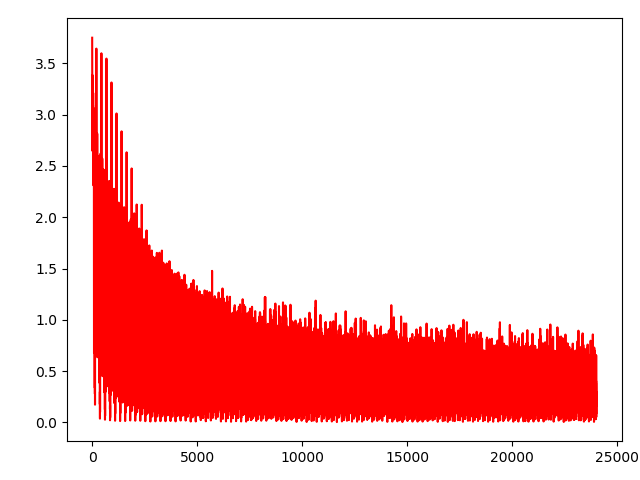

In [1]:
%matplotlib notebook
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
CUDA_LAUNCH_BLOCKING=1 

def load_file(file_name):
    file = open(file_name, 'r')
    text = file.read()
    file.close()
    text = text.split(' ')
    return text


def one_hot(idx, num_classes):
    one_hot_vector = [0] * num_classes
    one_hot_vector[idx] = 1
    return one_hot_vector

text = load_file('Ed_Sheeran_lyrics.txt')
text = ' '.join(text)
chars = sorted(list(set(text)))
char_to_idx = dict((char, idx) for idx, char in enumerate(chars))
idx_to_char = dict((idx, char) for idx, char in enumerate(chars))
voc_size = len(chars)    
sequences = list()
for i in range(12, len(text)):
    sequences.append(text[i - 12 : i + 1])
    
labels = []
inputs = []
for i in range(len(sequences) - 1):
    labels.append(sequences[i][-1])
    inputs.append(sequences[i][:-1])
print(inputs[29],labels[29])
    
inputs = np.array([[one_hot(char_to_idx[s], voc_size) for s in inputs[i]] for i in range(len(sequences) - 1)])
labels = np.array([char_to_idx[s] for s in labels])

inputs = torch.Tensor(inputs).cuda()
inputs = inputs.squeeze()
inputs = inputs.unsqueeze(dim=2)

class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.LSTM = nn.LSTM(voc_size, 50, 2)
        self.dropout = nn.Dropout(p=0.1)
        self.linear = nn.Linear(600, voc_size)
        self.hidden = nn.Parameter(torch.randn(2, 1, 50, requires_grad=True).cuda())
        self.cell = nn.Parameter(torch.randn(2, 1, 50, requires_grad=True).cuda())
    
    def forward(self, x):
        x, (_, _) = self.LSTM(x, (self.hidden, self.cell))
        x = self.dropout(x)
        #x = x.transpose(0, 1).contiguous()
        x = self.linear(x.view(-1))
        return x
            

net = Net().cuda()
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
labels = torch.LongTensor(labels).cuda()
labels = labels.unsqueeze(1)


loss_history = []
loss_iter_history = []
loss_curr_iter = 0

f, loss_axis = plt.subplots(1,1)
loss_axis.plot(loss_history, loss_iter_history, 'r')

plt.tight_layout()

In [5]:
net.load_state_dict(torch.load('/home/max/drake_gen.pth'))

In [4]:
torch.save(net.state_dict(),'/home/max/Ed_Sheeran_gen.pth')

In [2]:
curr_loss = 0
for epoch in range(100):
    for i in range(len(inputs)):
        optimizer.zero_grad()
    
        outputs = net(inputs[i])
        outputs = outputs.unsqueeze(0)
        loss = criterion(outputs, labels[i])
    
        loss.backward()
        curr_loss += loss.item()
    
        optimizer.step()
    
        if i % 100 == 99:
        
            loss_history.append(curr_loss / 100)
            loss_iter_history.append(loss_curr_iter)
            loss_curr_iter += 1
        
            loss_axis.lines[0].set_xdata(loss_iter_history)
            loss_axis.lines[0].set_ydata(loss_history)
        
            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
        
            curr_loss = 0
    #print(loss.item())
    

In [20]:
output = net(inputs[58])
print(inputs[1].shape)
output = output.unsqueeze(0)
print(output.shape)
print(output)
_, idx = torch.max(output, 1)
print(int(idx))
letter = idx_to_char[int(idx)]
print(letter)

torch.Size([15, 1, 64])
torch.Size([1, 64])
tensor([[ -0.9119,  -6.0164,  -2.1146,  -6.4726, -11.9659,  -9.8826,  -3.9757,
          -5.2905,  -3.2629,  -8.8371,  -3.2443,  -5.6747,  -4.7001,  -3.9999,
          -6.8052, -17.5755, -11.2934,  -8.7973,  -7.8454,  -7.4788,  -3.2021,
          -8.4003,  -9.2053,  -5.7925,  -3.2788,  -9.6651,  -6.6949,  -4.8262,
          -6.2483,  -3.6184,  -5.4279, -21.5714, -21.5818,  -6.7608,  -9.6218,
         -15.9388, -18.8570, -21.6180,   2.1940,  -2.5678,  -6.0344,  -2.7599,
           7.0723,  -3.0342,  -3.4636,  -1.0009,   3.4165,  -5.8993,  -3.6235,
          -0.3366,  -3.1919,  -4.0017,   2.3005,  -5.3878,  -6.2292,   0.9843,
          -3.6909,  -1.2643,  -1.6347,  -5.4257,  -3.0647,  -7.4275,  -0.4473,
         -10.6656]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
42
e


In [3]:
torch.save(net.state_dict(), '/home/max/drake_gen.pth')

In [24]:
start_sample = 'My friends t'
net.eval()
for i in range(175):
    inputs = np.array([one_hot(char_to_idx[s], voc_size) for s in start_sample[i : i + 15]])
    inputs = torch.Tensor(inputs).type(torch.cuda.FloatTensor)
    inputs = inputs.unsqueeze(1)
    outputs = net(inputs)
    outputs = outputs.unsqueeze(0)
    _, idx = torch.max(outputs, 1)
    letter = idx_to_char[int(idx)]
    start_sample += letter
print(start_sample)

My friends to the bed the flame
Oh roses roses laid upon your bed spread
Oh my, hold tes I'll get and the danger for arouke has enss
and'ney just left me on the shelf, no farewell
So befo


In [3]:
print(net.named_parameters.im_self())

TypeError: 'instancemethod' object has no attribute '__getitem__'

In [ ]:
output, hidden, cell = rnn(input, hidden, cell)
